In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')


for layer in base_model.layers[-20:]:  
    layer.trainable = True  

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  
    BatchNormalization(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.5),  
    Dense(6, activation='softmax')
])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  
              loss='sparse_categorical_crossentropy',  
              metrics=['accuracy'])


datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=40,  
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.3,
    zoom_range=0.4,
    brightness_range=[0.3, 1.7],
    horizontal_flip=True,
    fill_mode='nearest'
)


train_data = datagen.flow_from_directory(
    "dataset2/dataset/dataset",
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',
    subset="training"
)

val_data = datagen.flow_from_directory(
    "dataset2/dataset/dataset",
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',
    subset="validation"
)


class StopAtAccuracy(Callback):
    def __init__(self, target_acc=0.93):
        super(StopAtAccuracy, self).__init__()
        self.target_acc = target_acc

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= self.target_acc:  
            print(f"\nReached {self.target_acc*100}% accuracy! Stopping training.")
            self.model.stop_training = True


early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)
stop_at_91 = StopAtAccuracy(target_acc=0.91)


history = model.fit(
    train_data, 
    validation_data=val_data, 
    epochs=20,  
    callbacks=[early_stop, reduce_lr, stop_at_91]  
)


model.save("gesture_model_v2.h5")

Found 1920 images belonging to 6 classes.
Found 480 images belonging to 6 classes.


C:\Users\KIIT\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 136s 2s/step - accuracy: 0.5234 - loss: 5.7110 - val_accuracy: 0.4375 - val_loss: 5.4324 - learning_rate: 1.0000e-04
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9433 - loss: 4.2943
Reached 91.0% accuracy! Stopping training.
60/60 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - accuracy: 0.9435 - loss: 4.2935 - val_accuracy: 0.7750 - val_loss: 4.6767 - learning_rate: 1.0000e-04


Found 1471 images belonging to 5 classes.


C:\Users\KIIT\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


46/46 ━━━━━━━━━━━━━━━━━━━━ 40s 803ms/step

Test Accuracy: 87.42%

 Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       400
           1       0.93      1.00      0.96       486
           2       1.00      1.00      1.00       400
           3       0.00      0.00      0.00       100
           4       0.00      0.00      0.00        85
           5       0.00      0.00      0.00         0

    accuracy                           0.87      1471
   macro avg       0.45      0.50      0.47      1471
weighted avg       0.78      0.87      0.82      1471



C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\KIIT\anaconda3\Lib\site-packages\sklearn\metrics\_classif

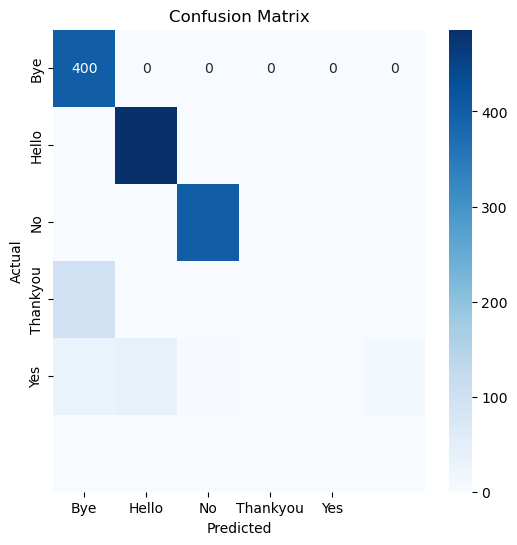

In [38]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model = tf.keras.models.load_model("gesture_model_v2.h5")


test_datagen = ImageDataGenerator(rescale=1./255)


test_data = test_datagen.flow_from_directory(
    "Test",  
    target_size=(128, 128),
    batch_size=32,
    class_mode='sparse',
    shuffle=False  
)


y_true = test_data.classes


y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1) 


test_accuracy = np.sum(y_pred_classes == y_true) / len(y_true)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")


print("\n Classification Report:")
print(classification_report(y_true, y_pred_classes))


cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=test_data.class_indices.keys(), yticklabels=test_data.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
